## Setup

In [633]:
%pip install openpyxl networkx matplotlib joblib powerlaw

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import seaborn as sns
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import powerlaw

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Process Excel Data

### Helper Functions

In [634]:
# Read the data into a DataFrame
def process_data(input_file, output_file, sheet_startup_names, sheet_startup_data, columns):
    df_startup_names = pd.read_excel(input_file, sheet_name=sheet_startup_names, header=None)
    df_startup_data = pd.read_excel(input_file, sheet_name=sheet_startup_data, header=None) 

    # Create a new DataFrame with reshaped data
    group_size = len(columns) - 1
    reshaped_df_startup_names = df_startup_names.iloc[0::2].reset_index(drop=True)
    reshaped_startup_data = pd.DataFrame(df_startup_data.values.reshape((-1, group_size)))

    deals_df = pd.concat([reshaped_df_startup_names, reshaped_startup_data], axis=1)
    deals_df.columns = columns.keys()
    deals_df = deals_df.astype(columns, errors="ignore")
    deals_df = deals_df.fillna("")
    deals_df = deals_df[deals_df['Investors'] != "nan"]

    # Save the transformed DataFrame back to Excel
    deals_df.to_excel(output_file, index=False, sheet_name="Transformed")

    print(f"Data successfully transformed and saved to {output_file}")

    return deals_df


In [635]:
def map_hq_locations_to_regions(df):
    unique_hq_locations = df['HQ Location'].unique()
    countries = pd.DataFrame([location.split(", ")[-1] for location in unique_hq_locations if location != 'nan'])

    # Define a mapping of countries to global sub-regions
    country_to_region = {
        'United Kingdom': 'Europe', 'CA': 'North America', 'IN': 'Asia', 'Ireland': 'Europe', 'Brazil': 'South America',
        'NC': 'North America', 'South Korea': 'Asia', 'DE': 'Europe', 'France': 'Europe', 'FL': 'North America',
        'Japan': 'Asia', 'India': 'Asia', 'MA': 'North America', 'Sweden': 'Europe', 'Germany': 'Europe',
        'Canada': 'North America', 'China': 'Asia', 'Israel': 'Asia', 'WA': 'North America', 'TX': 'North America',
        'Australia': 'Oceania', 'NY': 'North America', 'Finland': 'Europe', 'Singapore': 'Asia', 'Poland': 'Europe',
        'United Arab Emirates': 'Asia', 'US': 'North America', 'Turkey': 'Asia', 'CO': 'North America', 'Spain': 'Europe',
        'Mexico': 'North America', 'Portugal': 'Europe', 'Italy': 'Europe', 'OR': 'North America', 'IL': 'North America',
        'Argentina': 'South America', 'Switzerland': 'Europe', 'Luxembourg': 'Europe', 'OH': 'North America', 'Thailand': 'Asia',
        'MD': 'North America', 'Chile': 'South America', 'IA': 'North America', 'Austria': 'Europe', 'NJ': 'North America',
        'VA': 'North America', 'PR': 'North America', 'MO': 'North America', 'Vietnam': 'Asia', 'South Africa': 'Africa',
        'Romania': 'Europe', 'MI': 'North America', 'UT': 'North America', 'Denmark': 'Europe', 'Lithuania': 'Europe',
        'Hong Kong': 'Asia', 'Indonesia': 'Asia', 'Estonia': 'Europe', 'Norway': 'Europe', 'British Virgin Islands': 'North America',
        'Bulgaria': 'Europe', 'Egypt': 'Africa', 'CT': 'North America', 'Nigeria': 'Africa', 'Belgium': 'Europe',
        'Cayman Islands': 'North America', 'Netherlands': 'Europe', 'AZ': 'North America', 'Kenya': 'Africa', 'NE': 'North America',
        'HI': 'North America', 'Seychelles': 'Africa', 'PA': 'North America', 'Tajikistan': 'Asia', 'Uruguay': 'South America',
        'DC': 'North America', 'ID': 'North America', 'Cyprus': 'Europe', 'TN': 'North America', 'Saudi Arabia': 'Asia',
        'NV': 'North America', 'Greece': 'Europe', 'Taiwan': 'Asia', 'Malaysia': 'Asia', 'Colombia': 'South America', 'AL': 'North America',
        'Croatia': 'Europe', 'Oman': 'Asia', 'WV': 'North America', 'WI': 'North America', 'MT': 'North America', 'AR': 'North America',
        'New Zealand': 'Oceania', 'Qatar': 'Asia', 'GA': 'North America', 'Czech Republic': 'Europe', 'WY': 'North America', 'OK': 'North America',
        'Ukraine': 'Europe', 'KS': 'North America', 'Marshall Islands': 'Oceania', 'Iceland': 'Europe', 'Slovakia': 'Europe', 'SC': 'North America',
        'AK': 'North America', 'VT': 'North America', 'Malta': 'Europe', 'Tunisia': 'Africa', 'Pakistan': 'Asia', 'LA': 'North America',
        'Russia': 'Europe', 'Nicaragua': 'North America', 'Serbia': 'Europe', 'Philippines': 'Asia', 'Liechtenstein': 'Europe', 'Costa Rica': 'North America',
        'Gibraltar': 'Europe', 'Curacao': 'North America', 'Jordan': 'Asia', 'MN': 'North America', 'Saint Kitts and Nevis': 'North America',
        'Latvia': 'Europe', 'Hungary': 'Europe'
    }

    # Map the countries to their respective regions
    df['HQ Global Sub-Region'] = df['HQ Location'].apply(lambda x: country_to_region.get(x.split(", ")[-1], 'Unknown'))
    
    return df

In [636]:
# Filter the DataFrame to include only rows where the HQ Global Sub-Region matches the specified region
def filter_df_by_region(df, region):
    df = df[df['HQ Global Sub-Region'].isin(region)]

    return df

### Process Data

In [637]:
input_file_early_stage = "Startup Investor Data M&A.xlsx" 
output_file_early_stage= "transformed_file_early_stage_deals_data.xlsx" 
sheet_early_stage_names = "Early Stage Deals Startup Names"  
sheet_early_stage_data = "Early Stage Deals Data"  

columns_early_stage = {
	"Company Name": str,
	"Deal ID": str,
	"Deal Date": str,
	"Deal Type 2": str,
	"HQ Location": str,
	"Follow-on Investors": str,
	"New Investors": str,
	"Investors": str,
	"Financing Status": str,
	"Primary Industry Code": str,
	"Verticals": str,
	"Business Status": str
}

early_stage_deals_df = process_data(input_file_early_stage, output_file_early_stage, sheet_early_stage_names, sheet_early_stage_data, columns_early_stage)
early_stage_deals_df = map_hq_locations_to_regions(early_stage_deals_df)

Data successfully transformed and saved to transformed_file_early_stage_deals_data.xlsx


In [638]:
input_file_late_stage = "Startup Investor Data M&A.xlsx" 
output_file_late_stage= "transformed_file_late_stage_deals_data.xlsx" 
sheet_late_stage_names = "Late Stage Deals Startup Names"  
sheet_late_stage_data = "Late Stage Deals Data"  

columns_late_stage = {
	"Company Name": str,
	"Deal ID": str,
	"Deal Date": str,
	"Deal Type 2": str,
	"HQ Location": str,
    "HQ Global Sub-Region": str,
	"Follow-on Investors": str,
	"New Investors": str,
	"Investors": str,
	"Financing Status": str,
	"Primary Industry Code": str,
	"Verticals": str,
	"Business Status": str
}

late_stage_deals_df = process_data(input_file_late_stage, output_file_late_stage, sheet_late_stage_names, sheet_late_stage_data, columns_late_stage)

Data successfully transformed and saved to transformed_file_late_stage_deals_data.xlsx


In [639]:

input_file_investors = "Startup Investor Data M&A.xlsx" 
output_file_investors= "transformed_file_investor_data.xlsx" 
sheet_investor_names = "Investor Names"  
sheet_investor_data = "Investor Data"  

columns_investors = {
    "Investors": str,
    "Active Portfolio": str,
    "HQ Global Region": str,
    "HQ Global Sub Region": str,
    "HQ Location": str,
    "AUM": int,
    "Primary Investor Type": str
}

investors_df = process_data(input_file_investors, output_file_investors, sheet_investor_names, sheet_investor_data, columns_investors)

investors_df['Investors'] = investors_df['Investors'].apply(lambda x: x.split(" (")[0])

Data successfully transformed and saved to transformed_file_investor_data.xlsx


In [640]:
# Filter the DataFrame to include only rows where the HQ Global Sub-Region is 'North America' or 'South America'
early_stage_deals_df = filter_df_by_region(early_stage_deals_df, ['North America', 'South America'])
print(early_stage_deals_df['HQ Global Sub-Region'].unique())

# Filter the DataFrame to include only rows where the HQ Global Sub-Region is 'North America' or 'South America'
late_stage_deals_df = filter_df_by_region(late_stage_deals_df, ['North America', 'South America', 'Central America'])
print(late_stage_deals_df['HQ Global Sub-Region'].unique())

['North America' 'South America']
['North America' 'Central America' 'South America']


In [641]:
# Print distribution of regions in early_stage_deals_df
print("Distribution of regions in early_stage_deals_df:")
print(early_stage_deals_df['HQ Global Sub-Region'].value_counts(normalize=True))

# Print distribution of regions in late_stage_deals_df
print("\nDistribution of regions in late_stage_deals_df:")
print(late_stage_deals_df['HQ Global Sub-Region'].value_counts(normalize=True))

Distribution of regions in early_stage_deals_df:
HQ Global Sub-Region
North America    0.986261
South America    0.013739
Name: proportion, dtype: float64

Distribution of regions in late_stage_deals_df:
HQ Global Sub-Region
North America      0.993763
South America      0.004158
Central America    0.002079
Name: proportion, dtype: float64


In [642]:
# Extract individual investors from early stage and late stage dataframes
early_stage_investors = early_stage_deals_df['Investors'].str.replace('\xa0', ' ').str.split(', ').explode().unique()
late_stage_investors = late_stage_deals_df['Investors'].str.replace('\xa0', ' ').str.split(', ').explode().unique()

early_stage_investors = [investor.split(" (")[0] for investor in early_stage_investors]
late_stage_investors = [investor.split(" (")[0] for investor in late_stage_investors]

print(early_stage_investors)
# Combine the investors from both stages
all_investors = set(early_stage_investors).union(set(late_stage_investors))

# Create a dictionary where each key is mapped to itself
investor_dict = {investor: investor for investor in all_investors}


investor_dict["Animoca Ventures"] = "Animoca Brands"
investor_dict["B Capital China"] = "B Capital Group"
investor_dict["Betaworks"] = "Betaworks Ventures"
investor_dict["Blackstone Innovations Investments"] = "Blackstone (NYS: BX)"
# investor_dict["Cisco Systems (NAS: CSCO)"] = "Cisco Investments"
investor_dict["Connect Ventures (UK)"] = "Connect Ventures"
# investor_dict["Delphi Digital Consulting"] = "Delphi Ventures (New York)"
investor_dict["Good Games Labs"] = "Good Games Guild"  
investor_dict["Hash Global"] = "Hash Global Capital"
investor_dict["Hewlett Packard Pathfinder"] = "Hewlett Packard Enterprise (NYS: HPE)"
investor_dict["ICONIQ Growth"] = "ICONIQ Capital"
investor_dict["Incubate Fund US"] =  "Incubate Fund"
investor_dict["Lightspeed India Partners"] = "Lightspeed Venture Partners"
investor_dict["Lightspeed Venture Partners Israel"] = "Lightspeed Venture Partners"
investor_dict["Lightspeed Ventures"] = "Lightspeed Venture Partners"
investor_dict["Lotus Capital (Middle East)"] = "Lotus Capital"
# investor_dict["OpenAI Startup Fund"] = "OpenAI" 

print(len(investor_dict))

def get_investors(investor_str):
    investors_str = investor_str.replace('\xa0', ' ')
    investors = investors_str.split(", ")
    investors = [investor.split(" (")[0] for investor in investors] # Remove any additional information in parentheses
    investors = [investor_dict.get(investor, investor) for investor in investors]
    investors = list(set(investors))

    return investors

['AngelSpark', 'Beyond Capital', 'Flat6labs', 'Ghassan Halawa', 'Hisham Abu Bakr', 'Imad Ghazareddine', 'Karim Chouikri', 'Mahesh Murthy', 'Blu Stone Management', 'BOLD', 'Greycroft', 'Naver D2 Startup Factory', 'super{set}', 'The Trade Desk', 'Andreessen Horowitz', 'Assaf Wand', 'Carlos de Barros', 'Creditas Soluções Financeiras', 'David Vélez', 'Deli Matsuo', 'Endeavor Miami', 'Endeavor Promessas', 'Eugene Zagottis', 'Federico Mistrangelo', 'Josué de Alencar', 'Juan Vergara', 'K50 Ventures', 'KDX Ventures', 'Latitud', 'Luiz Nascimento', 'Mike Dixon', 'Pedro Faria', 'QED Investors', 'QuintoAndar', 'Randal Zanetti', 'Triangle Tweener Fund', 'ABCDE Capital', 'Acequia Capital', 'AimTop Ventures', 'Amber Group', 'Camford Capital', 'David Tse', 'Finality Capital Partners', 'IDG Capital', 'Jeff Ren', 'LDV Partners', 'Modular Capital', 'Plug and Play Tech Center', 'Prime Set', 'Road Capital Management', 'Silicon Valley Future Capital', 'Sparkle Ventures', 'Sreeram Kannan', 'USC Marshall Scho

In [643]:
# Find common investors
common_investors = set(late_stage_investors).intersection(set(investors_df['Investors']))

# Filter investors_df to include only common investors
common_investors_df = investors_df[investors_df['Investors'].isin(common_investors)]

# Print the distribution of primary investor type
primary_investor_type_distribution = common_investors_df['HQ Global Region'].value_counts(normalize=True)
print("Distribution of Primary Investor Type in common investors:")
print(primary_investor_type_distribution)

Distribution of Primary Investor Type in common investors:
HQ Global Region
Americas       0.791511
Asia           0.088639
Europe         0.066167
Middle East    0.033708
Oceania        0.009988
nan            0.007491
Africa         0.002497
Name: proportion, dtype: float64


## Network Graph & Helper Functions

### Network Functions

In [644]:

# Create a network graph from the data
def create_network_graph(df):
    G = nx.Graph()
    # Iterate through each row in the DataFrame
    for idx, row in df.iterrows():
        investors = get_investors(row['Investors'])
        for investor in investors:
            if not G.has_node(investor):
                G.add_node(investor)
                # Add attributes to the node from the investors_df
                if investor in investors_df['Investors'].values:
                    investor_data = investors_df[investors_df['Investors'] == investor].iloc[0]
                    G.nodes[investor].update(investor_data.to_dict())

        # Add edges between investors in the same list
        for investor1, investor2 in combinations(investors, 2):
            if not G.has_edge(investor1, investor2):
                G.add_edge(investor1, investor2, weight=1)
            else:
                G.edges[investor1, investor2]["weight"] += 1

    return G


In [645]:
def filter_graph_by_edge_weight(G, min_weight):
    filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] >= min_weight]
    G_filtered = nx.Graph()
    G_filtered.add_edges_from(filtered_edges)

    # Add node attributes to the filtered graph
    for node, data in G.nodes(data=True):
        if node in G_filtered:
            G_filtered.nodes[node].update(data)

    return G_filtered

In [646]:
def create_common_graph(G1, G2):
    # Create a new graph with the common edges of G1 and G2
    common_edges = set(G1.edges()).intersection(set(G2.edges()))
    G_common = nx.Graph()
    
    # Add edges with weights from G1
    for u, v, data in G1.edges(data=True):
        if (u, v) in common_edges or (v, u) in common_edges:
            G_common.add_edge(u, v, weight=data['weight'])

    # Add edges with weights from G2
    for u, v, data in G2.edges(data=True):
        if (u, v) in common_edges or (v, u) in common_edges:
            if G_common.has_edge(u, v):
                G_common[u][v]['weight'] += data['weight']
            else:
                G_common.add_edge(u, v, weight=data['weight'])

    # Add node attributes to the common graph
    for node, data in G1.nodes(data=True):
        if node in G_common:
            G_common.nodes[node].update(data)
    
    return G_common

In [647]:
def combine_graphs(G1, G2):
    """
    Combine two graphs G1 and G2 into a single graph.
    Nodes and edges from both graphs are added to the combined graph.
    If an edge exists in both graphs, their weights are summed.
    """
    G_combined = nx.Graph()

    # Add nodes and edges from G1
    for u, v, data in G1.edges(data=True):
        if G_combined.has_edge(u, v):
            G_combined[u][v]['weight'] += data['weight']
        else:
            G_combined.add_edge(u, v, weight=data['weight'])

    # Add nodes and edges from G2
    for u, v, data in G2.edges(data=True):
        if G_combined.has_edge(u, v):
            G_combined[u][v]['weight'] += data['weight']
        else:
            G_combined.add_edge(u, v, weight=data['weight'])

    # Add node attributes from G1
    for node, data in G1.nodes(data=True):
        if node in G_combined:
            G_combined.nodes[node].update(data)
        else:
            G_combined.add_node(node, **data)

    # Add node attributes from G2
    for node, data in G2.nodes(data=True):
        if node in G_combined:
            G_combined.nodes[node].update(data)
        else:
            G_combined.add_node(node, **data)

    return G_combined

In [648]:
def generate_configuration_model(G, seed=None):
    """
    Generates a Configuration Model (CM) equivalent of the given graph.

    Parameters:
    - G (networkx.Graph): The input graph.
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - G_cm (networkx.Graph): The Configuration Model graph with the same degree distribution as G.
    """
    degree_sequence = [d for _, d in G.degree()]  # Extract degree sequence

    # Extract edge weights and shuffle them
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    np.random.shuffle(edge_weights)

    # Generate Configuration Model using degree sequence
    CM = nx.configuration_model(degree_sequence, seed=seed)

    # Convert MultiGraph to Simple Graph (removes parallel edges & self-loops)
    G_cm = nx.Graph(CM)

    # Ensure the same number of nodes as original graph
    G_cm.remove_edges_from(nx.selfloop_edges(G_cm))  # Remove self-loops

    for (u, v), weight in zip(G_cm.edges(), edge_weights):
        G_cm[u][v]['weight'] = weight

    return G_cm

In [649]:
def generate_er_equivalent(G, seed=None):
    """
    Generates an Erdős–Rényi (ER) model equivalent to the given graph.

    Parameters:
    - G (networkx.Graph): The input graph.
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - G_er (networkx.Graph): The equivalent Erdős–Rényi random graph.
    """
    n = G.number_of_nodes()
    m = G.number_of_edges()

    if n < 2:
        raise ValueError("Graph must have at least 2 nodes for an ER model.")

    p = (2 * m) / (n * (n - 1))  # Probability of an edge based on density
    G_er = nx.erdos_renyi_graph(n, p, seed=seed)

    for u, v in G_er.edges():
        G_er[u][v]['weight'] = 1

    return G_er

### Helper Functions

In [650]:
def calculate_graph_metrics(G):
    # Calculate number of nodes
    num_nodes = G.number_of_nodes()

    # Calculate number of edges
    num_edges = G.number_of_edges()

    # Calculate average degree
    degrees = np.array([d for _, d in G.degree()])
    avg_degree = degrees.mean()
    
    # Calculate average weighted degree
    avg_weighted_degree = sum(sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()) / len(G.nodes())

    # Calculate density
    density = nx.density(G)

    # Compute power-law exponent using MLE
    # degrees_sequence = np.array([d for _, d in G.degree() if d > 0])
    # k_min = min(degrees_sequence)  # Smallest degree
    # alpha = 1 + len(degrees_sequence) / sum(np.log(degrees_sequence / k_min))

    alpha = powerlaw.Fit(degrees, verbose=False).alpha

    # Calculate number of connected components
    components = list(nx.connected_components(G))
    num_connected_components = len(components)

    # Calculate clustering coefficeints
    clustering_with_zero = nx.average_clustering(G, weight=None)
    clustering_without_zero = nx.average_clustering(G, count_zeros=False)
    weighted_clustering_with_zero = nx.average_clustering(G, weight='weight')
    weighted_clustering_without_zero = nx.average_clustering(G, weight='weight', count_zeros=False)
    
   # Compute network diameter and average path length efficiently
    if num_connected_components == 1:
        # Single component (connected graph)
        diameter = nx.diameter(G)
        avg_path_length = nx.average_shortest_path_length(G)
    else:
        # Multi-component (disconnected graph) -> Use parallelization
        subgraphs = [G.subgraph(c).copy() for c in components]
        
        diameters = Parallel(n_jobs=-1)(delayed(nx.diameter)(sg) for sg in subgraphs)
        diameter = max(diameters)

        avg_path_lengths = Parallel(n_jobs=-1)(
            delayed(nx.average_shortest_path_length)(sg) for sg in subgraphs
        )
        avg_path_length = np.mean(avg_path_lengths)
    
    return {
        "Number of Nodes": num_nodes,
        "Number of Edges": num_edges,
        "Average Degree": round(avg_degree, 3),
        "Average Weighted Degree": round(avg_weighted_degree, 3),
        "Network Diameter": diameter,
        "Density": round(density, 5),
        "Power Law Exponent": alpha,
        "Connected Components": num_connected_components,
        "Clustering Coefficient with Zero": round(clustering_with_zero, 3),
        "Clustering Coefficient without Zero": round(clustering_without_zero, 3),
        "Weighted Clustering Coefficient": round(weighted_clustering_with_zero, 3),
        "Weighted Clustering Coefficient without Zero": round(weighted_clustering_without_zero, 3),
        "Average Path Length": avg_path_length
    }

In [651]:
def print_graph_metrics(metrics, graph_name):
    print(f"{graph_name} Graph Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value}")

In [652]:
def calculate_percentile_degree(G, percentile=90):
    # Calculate the degree of each node for the graph
    node_degrees = dict(G.degree())

    # Sort nodes by degree in descending order for the graph
    sorted_degrees = sorted(node_degrees.values(), reverse=True)

    # Find the degree of the specified percentile for the graph
    percentile_degree = np.percentile(sorted_degrees, percentile)

    return percentile_degree

In [653]:
# Calculate the degree and sum of edge weights for each node
def calculate_weights_degrees_ratio(G):
    node_degrees = dict(G.degree())
    node_edge_weights = {node: sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()}

    # Calculate the ratio of degree to sum of edge weights for each node
    weight_degree_ratio = {node: node_edge_weights[node] / node_degrees[node] if node_degrees[node] != 0 else 0 for node in G.nodes()}

    # Convert to DataFrame for plotting
    weight_degree_ratio_df = pd.DataFrame(list(weight_degree_ratio.items()), columns=['Node', 'Weight/Degree Ratio'])

    return weight_degree_ratio_df

### Plotting Functions

In [654]:
def plot_ccdf_of_graph(G):
    """
    Plot the complementary cumulative degree distribution (CCDF) of a graph G.
    """

    # 1. Compute the degree of each node
    degrees = [deg for _, deg in G.degree()]

    # 2. Count how many nodes have each degree
    max_degree = max(degrees)
    degree_counts = np.bincount(degrees, minlength=max_degree+1)

    # 3. Calculate the probability mass function (PMF)
    #    for each degree: P(degree = k) = (count of nodes with degree k) / (total nodes)
    total_nodes = G.number_of_nodes()
    pmf = degree_counts / total_nodes

    # 4. Convert PMF to a cumulative distribution function (CDF):
    #    CDF(k) = sum_{i=0..k} P(degree = i)
    cdf = np.cumsum(pmf)

    # 5. Compute the complementary CDF (CCDF) = 1 - CDF
    ccdf = 1 - cdf

    # 6. Plot the CCDF (optionally on a log-log scale, common for degree distributions)
    plt.figure(figsize=(7, 5))
    plt.loglog(range(max_degree+1), ccdf, marker='x', linestyle='none')
    plt.xlabel('Degree (k)')
    plt.ylabel('CCDF (1 - F(k))')
    plt.title('Complementary Cumulative Degree Distribution')
    plt.grid(True)
    plt.show()


In [655]:
# Plot weight/degree ratio
def plot_weight_degree_ratio(weight_degree_ratio_df):
    plt.figure(figsize=(10, 6))
    sns.histplot(weight_degree_ratio_df['Weight/Degree Ratio'], bins=30, kde=True)
    plt.xlabel('Weight/Degree Ratio')
    plt.ylabel('Frequency')
    plt.title('Distribution of Weight/Degree Ratio for All Nodes')
    plt.grid(True)
    plt.show()

## Generate Graphs

In [656]:
G_early_stage = create_network_graph(early_stage_deals_df)
G_early_stage_filtered = filter_graph_by_edge_weight(G_early_stage, min_weight=2)
G_early_stage_filtered_ER = generate_er_equivalent(G_early_stage_filtered)

G_late_stage = create_network_graph(late_stage_deals_df)
G_late_stage_filtered = filter_graph_by_edge_weight(G_late_stage, min_weight=2)
G_late_stage_filtered_ER = generate_er_equivalent(G_late_stage_filtered)

G_combined_unfiltered = combine_graphs(G_early_stage, G_late_stage)
G_combined_filtered = combine_graphs(G_early_stage_filtered, G_late_stage_filtered)

G_common_unfiltered = create_common_graph(G_early_stage, G_late_stage)
G_common_filtered = create_common_graph(G_early_stage_filtered, G_late_stage_filtered)

# Calculate the weighted degree for each node
weighted_degrees = {node: sum(data['weight'] for _, _, data in G_combined_filtered.edges(node, data=True)) for node in G_combined_filtered.nodes()}

# Sort nodes by weighted degree in descending order
sorted_weighted_degrees = sorted(weighted_degrees.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes with highest weighted degrees
print("Nodes with highest weighted degrees:")
for node, degree in sorted_weighted_degrees[:10]:
    print(f"Node: {node}, Weighted Degree: {degree}")


Nodes with highest weighted degrees:
Node: Andreessen Horowitz, Weighted Degree: 370
Node: Sequoia Capital, Weighted Degree: 300
Node: Coatue Management, Weighted Degree: 244
Node: Y Combinator, Weighted Degree: 244
Node: Tiger Global Management, Weighted Degree: 211
Node: Lux Capital, Weighted Degree: 177
Node: Lightspeed Venture Partners, Weighted Degree: 171
Node: Khosla Ventures, Weighted Degree: 167
Node: ICONIQ Capital, Weighted Degree: 166
Node: GV, Weighted Degree: 136


In [657]:
# Get the list of all nodes in the graph
all_nodes = set(G_combined_filtered.nodes())

# Get the list of investors in the investors_df
investors_in_df = set(investors_df['Investors'])

# Find nodes that are not in investors_df
nodes_not_in_df = all_nodes - investors_in_df

# Print the nodes not in investors_df
print("Nodes not in investors_df:")
for node in nodes_not_in_df:
    print(node)

    # Create a DataFrame from the list of nodes not in investors_df
    nodes_not_in_df_df = pd.DataFrame(list(nodes_not_in_df), columns=["Firm Name"])

    # Save the DataFrame to a CSV file
    nodes_not_in_df_df.to_csv("nodes_not_in_investors_df.csv", index=False)

Nodes not in investors_df:
Chih-Yuan Yang
ISTARI
Nicholas Frosst
Peter Killalea
Joseph Speiser
Growth Factory
Patrick McCormick
BOLD
Jeffrey Bonforte
Andrew Daniels
Alexander Atallah
NVentures
Samuel Teller
Blackstone (NYS: BX)
Hewlett Packard Enterprise (NYS: HPE)
Michael Jarmuz
Firsthand.VC
OpenOcean


## Graph Properties

<Axes: >

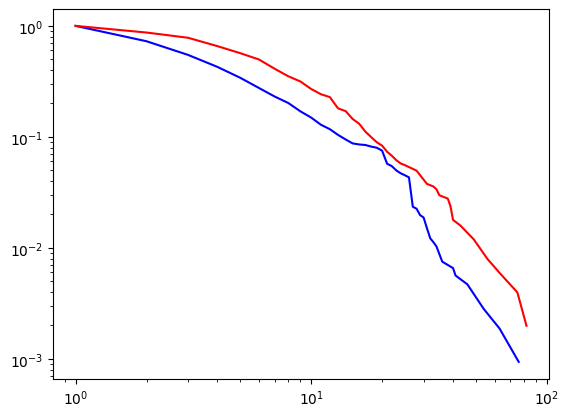

In [658]:
powerlaw.plot_ccdf([d for _, d in G_early_stage_filtered.degree()], color='b', label='Early Stage')
powerlaw.plot_ccdf([d for _, d in G_late_stage_filtered.degree()], color='r', label='Late Stage')

In [659]:
# Calculate metrics for early stage unfiltered graph
metrics_early_stage_unfiltered = calculate_graph_metrics(G_early_stage)
print_graph_metrics(metrics_early_stage_unfiltered, "Early Stage Unfiltered")

# Calculate metrics for late stage unfiltered graph
metrics_late_stage_unfiltered = calculate_graph_metrics(G_late_stage)
print_graph_metrics(metrics_late_stage_unfiltered, "\nLate Stage Unfiltered")

Early Stage Unfiltered Graph Metrics:
Number of Nodes: 6069
Number of Edges: 63320
Average Degree: 20.867
Average Weighted Degree: 21.993
Network Diameter: 10
Density: 0.00344
Power Law Exponent: 3.299078976073484
Connected Components: 498
Clustering Coefficient with Zero: 0.762
Clustering Coefficient without Zero: 0.843
Weighted Clustering Coefficient: 0.044
Weighted Clustering Coefficient without Zero: 0.049
Average Path Length: 0.20231118939711532
xmin progress: 99%
Late Stage Unfiltered Graph Metrics:
Number of Nodes: 2088
Number of Edges: 24414
Average Degree: 23.385
Average Weighted Degree: 26.058
Network Diameter: 9
Density: 0.01121
Power Law Exponent: 2.9893382263125927
Connected Components: 35
Clustering Coefficient with Zero: 0.832
Clustering Coefficient without Zero: 0.847
Weighted Clustering Coefficient: 0.113
Weighted Clustering Coefficient without Zero: 0.115
Average Path Length: 0.6001791053745565


In [660]:
# Calculate metrics for early stage filtered graph
metrics_early_stage_filtered = calculate_graph_metrics(G_early_stage_filtered)
print_graph_metrics(metrics_early_stage_filtered, "Early Stage Filtered")

# Calculate metrics for late stage filtered graph
metrics_late_stage_filtered = calculate_graph_metrics(G_late_stage_filtered)
print_graph_metrics(metrics_late_stage_filtered, "\nLate Stage Filtered")

Early Stage Filtered Graph Metrics:
Number of Nodes: 1066
Number of Edges: 2963
Average Degree: 5.559
Average Weighted Degree: 11.974
Network Diameter: 11
Density: 0.00522
Power Law Exponent: 5.036881854176157
Connected Components: 67
Clustering Coefficient with Zero: 0.496
Clustering Coefficient without Zero: 0.722
Weighted Clustering Coefficient: 0.06
Weighted Clustering Coefficient without Zero: 0.087
Average Path Length: 1.0798677603458153
xmin progress: 97%
Late Stage Filtered Graph Metrics:
Number of Nodes: 504
Number of Edges: 2096
Average Degree: 8.317
Average Weighted Degree: 19.393
Network Diameter: 7
Density: 0.01654
Power Law Exponent: 3.2052209531999907
Connected Components: 18
Clustering Coefficient with Zero: 0.679
Clustering Coefficient without Zero: 0.794
Weighted Clustering Coefficient: 0.192
Weighted Clustering Coefficient without Zero: 0.225
Average Path Length: 1.1858126043109265


In [661]:
# Calculate metrics for early stage filtered CM graph
metrics_early_stage_filtered_ER = calculate_graph_metrics(G_early_stage_filtered_ER)
print_graph_metrics(metrics_early_stage_filtered_ER, "Early Stage Filtered ER")

# Calculate metrics for late stage filtered CM graph
metrics_late_stage_filtered_ER = calculate_graph_metrics(G_late_stage_filtered_ER)
print_graph_metrics(metrics_late_stage_filtered_ER, "\nLate Stage Filtered ER")

Early Stage Filtered ER Graph Metrics:
Number of Nodes: 1066
Number of Edges: 2996
Average Degree: 5.621
Average Weighted Degree: 5.621
Network Diameter: 8
Density: 0.00528
Power Law Exponent: 81.96294940514937
Connected Components: 6
Clustering Coefficient with Zero: 0.005
Clustering Coefficient without Zero: 0.069
Weighted Clustering Coefficient: 0.005
Weighted Clustering Coefficient without Zero: 0.069
Average Path Length: 0.703156509522878
xmin progress: 92%
Late Stage Filtered ER Graph Metrics:
Number of Nodes: 504
Number of Edges: 2054
Average Degree: 8.151
Average Weighted Degree: 8.151
Network Diameter: 6
Density: 0.0162
Power Law Exponent: 7.443489410855018
Connected Components: 2
Clustering Coefficient with Zero: 0.016
Clustering Coefficient without Zero: 0.044
Weighted Clustering Coefficient: 0.016
Weighted Clustering Coefficient without Zero: 0.044
Average Path Length: 1.601197595304666


In [662]:
# Calculate metrics for combined unfiltered graph
metrics_combined_unfiltered = calculate_graph_metrics(G_combined_unfiltered)
print_graph_metrics(metrics_combined_unfiltered, "Combined Unfiltered")

# Calculate metrics for combined filtered graph
metrics_combined_filtered = calculate_graph_metrics(G_combined_filtered)
print_graph_metrics(metrics_combined_filtered, "\nCombined Filtered")

Combined Unfiltered Graph Metrics:
Number of Nodes: 7362
Number of Edges: 86992
Average Degree: 23.633
Average Weighted Degree: 25.521
Network Diameter: 8
Density: 0.00321
Power Law Exponent: 3.1850176615115555
Connected Components: 498
Clustering Coefficient with Zero: 0.76
Clustering Coefficient without Zero: 0.826
Weighted Clustering Coefficient: 0.045
Weighted Clustering Coefficient without Zero: 0.049
Average Path Length: 0.19555088291542005
xmin progress: 98%
Combined Filtered Graph Metrics:
Number of Nodes: 1448
Number of Edges: 5005
Average Degree: 6.913
Average Weighted Degree: 15.565
Network Diameter: 11
Density: 0.00478
Power Law Exponent: 4.049018392701801
Connected Components: 72
Clustering Coefficient with Zero: 0.554
Clustering Coefficient without Zero: 0.743
Weighted Clustering Coefficient: 0.068
Weighted Clustering Coefficient without Zero: 0.092
Average Path Length: 1.0778900929884436


In [663]:
# Calculate metrics for common unfiltered graph
metrics_common_unfiltered = calculate_graph_metrics(G_common_unfiltered)
print_graph_metrics(metrics_common_unfiltered, "Common Unfiltered")

# Calculate metrics for common filtered graph
metrics_common_filtered = calculate_graph_metrics(G_common_filtered)
print_graph_metrics(metrics_common_filtered, "\nCommon Filtered")

Common Unfiltered Graph Metrics:
Number of Nodes: 332
Number of Edges: 478
Average Degree: 2.88
Average Weighted Degree: 7.801
Network Diameter: 8
Density: 0.0087
Power Law Exponent: 3.0736462662446344
Connected Components: 41
Clustering Coefficient with Zero: 0.23
Clustering Coefficient without Zero: 0.582
Weighted Clustering Coefficient: 0.04
Weighted Clustering Coefficient without Zero: 0.101
Average Path Length: 1.1533955775582314
xmin progress: 83%
Common Filtered Graph Metrics:
Number of Nodes: 39
Number of Edges: 43
Average Degree: 2.205
Average Weighted Degree: 14.359
Network Diameter: 7
Density: 0.05803
Power Law Exponent: 3.5907237862470955
Connected Components: 3
Clustering Coefficient with Zero: 0.117
Clustering Coefficient without Zero: 0.416
Weighted Clustering Coefficient: 0.053
Weighted Clustering Coefficient without Zero: 0.186
Average Path Length: 1.7568627450980392


In [664]:
# Calculate the weight/degree ratio DataFrame
weight_degree_ratio_df = calculate_weights_degrees_ratio(G_early_stage_filtered)
weight_degree_ratio_df = weight_degree_ratio_df.sort_values(by='Weight/Degree Ratio', ascending=False)

print(weight_degree_ratio_df.head(30))
print(weight_degree_ratio_df[weight_degree_ratio_df['Node'] == 'Sequoia Capital'])

# plot_weight_degree_ratio(weight_degree_ratio_df)

                            Node  Weight/Degree Ratio
621                         SOSV             5.000000
706                          Inc             5.000000
622                          HAX             5.000000
707                     Founders             5.000000
390                 Daniel Gross             4.666667
193                Amino Capital             4.250000
215          Twenty Two Ventures             3.500000
42                  Nat Friedman             3.285714
28                  Y Combinator             3.142857
90                   10X Capital             3.100000
120              Cervin Ventures             3.000000
225            Christopher Golda             3.000000
816                    Biz Stone             3.000000
815                   Evan Sharp             3.000000
157        Samsung NEXT Ventures             3.000000
611            Balderton Capital             3.000000
226                  Kevin Moore             3.000000
862               Sangha Cap

## Centrality Analysis

### Calculations

In [665]:
betweenness_centrality_es = nx.betweenness_centrality(G_early_stage_filtered)
closeness_centrality_es = nx.closeness_centrality(G_early_stage_filtered)
eigenvector_centrality_es = nx.eigenvector_centrality(G_early_stage_filtered)
eigenvector_centrality_es_weigthed = nx.eigenvector_centrality(G_early_stage_filtered, weight='weight', tol=1e-5)
eigenvector_centrality_ls = nx.eigenvector_centrality(G_late_stage_filtered)


betweenness_centrality_ls = nx.betweenness_centrality(G_late_stage_filtered)
closeness_centrality_ls = nx.closeness_centrality(G_late_stage_filtered)


In [666]:
cross_betweenness = nx.betweenness_centrality_subset(
    G=G_combined_filtered, 
    sources=set(G_early_stage_filtered.nodes()),      # all early-stage investors
    targets=set(G_late_stage_filtered.nodes()),      # all late-stage investors
    normalized=True       # usually want it normalized
)

print(cross_betweenness)

{'Greycroft': 0.0015992176662085883, 'BOLD': 0.0, 'Bain Capital Ventures': 0.003310382873339532, 'Lightspeed Venture Partners': 0.019872890950526877, 'Lip-Bu Tan': 0.0005548532210606499, 'Recall Capital': 0.00022319273624736064, 'Sequoia Capital': 0.019302083762642648, 'FPV Ventures': 7.667566575270034e-06, 'SV Angel': 0.010511646165726201, 'BDMI': 9.205936244217225e-06, 'Elad Gil': 0.0021140079488196433, 'Plug and Play Tech Center': 0.012448896350824846, 'Operator Partners': 0.002556455394690499, 'Good Growth Capital': 2.4695365821805706e-05, 'Gary Wood': 0.0, 'Breyer Capital': 0.0017895006519261793, 'Revolution': 8.280171333002215e-05, 'BootstrapLabs': 0.0, 'Andreessen Horowitz': 0.04282478755878926, 'Coatue Management': 0.014497307783821, 'Essence Venture Capital': 0.0011849092109443707, 'The General Partnership': 0.0, 'Marianna Tessel': 0.0, 'John Lilly': 1.1664214092173598e-05, 'Don MacAskill': 0.0, 'Neha Narkhede': 4.290812358329768e-05, 'Peter Killalea': 0.0, 'TIAA Ventures': 0.

### Logs and Plots

In [681]:
top_nodes = sorted(eigenvector_centrality_es.items(), key=lambda x: x[1], reverse=True)[:20]
# Calculate the rank of these top nodes in the full late_stage_filtered graph based on degree
node_degrees_late_stage = dict(G_early_stage_filtered.degree())
# Sort node degrees in descending order and create a rank dictionary
sorted_node_degrees_late_stage = sorted(set(node_degrees_late_stage.values()), reverse=True)
degree_rank = {degree: rank + 1 for rank, degree in enumerate(sorted_node_degrees_late_stage)}

print(sorted_node_degrees_late_stage)
top_nodes_rank = {node: degree_rank[node_degrees_late_stage[node]] for node, _ in top_nodes}

# Print the rank of the top nodes
print("Rank of top nodes in the full late_stage_filtered graph based on degree:")
for node, rank in top_nodes_rank.items():
    print(f"Node: {node}, ES: {eigenvector_centrality_es[node]}, Rank: {rank}")


[76, 63, 54, 46, 41, 40, 36, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
Rank of top nodes in the full late_stage_filtered graph based on degree:
Node: Kevin Lin, ES: 0.19561830810012334, Rank: 8
Node: Roham Gharegozlou, ES: 0.19472830243270553, Rank: 8
Node: Jeffrey Zirlin, ES: 0.1942149420161502, Rank: 12
Node: Gabby Dizon, ES: 0.1938628572652232, Rank: 13
Node: Patrick Lee, ES: 0.19355924569728014, Rank: 10
Node: Holly Liu, ES: 0.19327509308735882, Rank: 14
Node: ACTAI Ventures, ES: 0.19162722698817303, Rank: 15
Node: Holly Branson, ES: 0.19135611743472028, Rank: 16
Node: George Kikvadze, ES: 0.19135611743472028, Rank: 16
Node: Kun Gao, ES: 0.19135611743472028, Rank: 16
Node: Bobby Lee, ES: 0.19135611743472028, Rank: 16
Node: Peach.xyz, ES: 0.19135611743472028, Rank: 16
Node: Stoked Capital, ES: 0.19135611743472028, Rank: 16
Node: Matthew Tan, ES: 0.19135611743472028, Rank: 16
Node: Sam Branson, ES: 0

## Community Analysis

In [668]:
# calculate the modularity and communities
communities = nx.algorithms.community.louvain_communities(G_early_stage_filtered)
modularity = nx.algorithms.community.modularity(G_early_stage_filtered, communities)
print(f"Modularity: {modularity}")

Modularity: 0.7552031155275435


In [687]:
# Sort communities by size
sorted_communities = sorted(communities, key=len, reverse=True)

# Get the top 5 largest communities
top_5_communities = sorted_communities[:10]

# Create a DataFrame to store the region distribution of the top 5 communities
region_distribution = pd.DataFrame()

# Print the sizes of the top 5 communities
for i, community in enumerate(top_5_communities):
    print(f"Community {i+1} Size: {len(community)}")
    
# Calculate the region distribution for each of the top 5 communities
for i, community in enumerate(top_5_communities):
    common_investors = set(investors_df['Investors']).intersection(community)
    community_df = investors_df[investors_df['Investors'].isin(common_investors)]
    region_distribution[f'Community {i+1}'] = community_df['HQ Location'].value_counts(normalize=True)
    investor_type_distribution = community_df['Primary Investor Type'].value_counts(normalize=True)
    print(f"Community {i+1} Investor Type Distribution: {investor_type_distribution.sort_values(ascending=False).head(5)}")
    # print(f"Community {i+1} Region Distribution: {region_distribution[f'Community {i+1}'].sort_values(ascending=False).head(5)}")




Community 1 Size: 159
Community 2 Size: 137
Community 3 Size: 71
Community 4 Size: 62
Community 5 Size: 56
Community 6 Size: 50
Community 7 Size: 45
Community 8 Size: 39
Community 9 Size: 37
Community 10 Size: 37
Community 1 Investor Type Distribution: Primary Investor Type
Venture Capital              0.590361
Angel (individual)           0.271084
Corporate Venture Capital    0.036145
Corporation                  0.024096
Accelerator/Incubator        0.018072
Name: proportion, dtype: float64
Community 2 Investor Type Distribution: Primary Investor Type
Venture Capital              0.722222
Angel (individual)           0.083333
VC-Backed Company            0.062500
Corporation                  0.041667
Corporate Venture Capital    0.034722
Name: proportion, dtype: float64
Community 3 Investor Type Distribution: Primary Investor Type
Venture Capital              0.819444
Angel (individual)           0.069444
Family Office                0.041667
Corporate Venture Capital    0.013889
Ang

## Assortativity

In [670]:
# Calculate the assortativity coefficient for the early stage filtered graph
assortativity_coefficient_early_stage = nx.degree_assortativity_coefficient(G_early_stage_filtered)
print(f"Assortativity Coefficient (Early Stage): {assortativity_coefficient_early_stage}")

# Calculate the assortativity coefficient for the late stage filtered graph
assortativity_coefficient_late_stage = nx.degree_assortativity_coefficient(G_late_stage_filtered)
print(f"Assortativity Coefficient (Late Stage): {assortativity_coefficient_late_stage}")

# Calculate the average neighbor degree for the early stage filtered graph
avg_neighbor_degree_early_stage = nx.average_neighbor_degree(G_early_stage_filtered)
sorted_avg_neighbor_degree_early_stage = dict(sorted(avg_neighbor_degree_early_stage.items(), key=lambda item: item[1], reverse=True))
print(f"Average Neighbor Degree (Early Stage): {sorted_avg_neighbor_degree_early_stage}")

# Calculate the average neighbor degree for the late stage filtered graph
avg_neighbor_degree_late_stage = nx.average_neighbor_degree(G_late_stage_filtered)
sorted_avg_neighbor_degree_late_stage = dict(sorted(avg_neighbor_degree_late_stage.items(), key=lambda item: item[1], reverse=True))
print(f"Average Neighbor Degree (Late Stage): {sorted_avg_neighbor_degree_late_stage}")

# Print degree of 'Animoca Brands'
degree_animoca_brands = G_early_stage_filtered.degree('Animoca Ventures')
print(f"Degree of Animoca Brands: {degree_animoca_brands}")

# Print weighted degree
weighted_degree_animoca_brands = sum(data['weight'] for _, _, data in G_early_stage_filtered.edges('Animoca Ventures', data=True))
print(f"Weighted Degree of Animoca Brands: {weighted_degree_animoca_brands}")

Assortativity Coefficient (Early Stage): 0.11416603576654444
Assortativity Coefficient (Late Stage): 0.039025308874459055
Average Neighbor Degree (Early Stage): {'10x Founders': 76.0, 'Prototype Capital': 76.0, '20VC': 76.0, 'Eileen Burbidge': 76.0, 'Ben Tossell': 76.0, 'Recursion Venture Capital': 76.0, 'Paul Buchheit': 76.0, 'Joseph Thomas': 76.0, 'HubSpot Ventures': 69.5, 'Oliver Jung': 69.5, 'Dharmesh Shah': 63.0, 'Richard Aberman': 63.0, 'Bantam Group': 63.0, 'Samvit Ramadurgam': 63.0, 'Ivan Kirigin': 63.0, 'Fellows Fund': 58.0, 'K50 Ventures': 54.0, 'Mergus Ventures': 54.0, 'Mark Pincus': 54.0, 'Point72 Ventures': 54.0, 'Justin Waldron': 54.0, '11.2 Capital': 54.0, 'Kraken Ventures': 54.0, 'Position Ventures': 54.0, 'Dreamers VC': 54.0, 'Coughdrop Capital': 52.0, 'Twenty Two Ventures': 52.0, 'OneValley Ventures': 52.0, 'Leonis Investissement': 52.0, 'Lombardstreet Ventures': 52.0, '8vdX': 52.0, 'FundersClub': 52.0, 'VentureSouq': 52.0, 'Mike Krieger': 50.0, 'Haystack Management C

## Rich-Club

In [678]:


# Example usage for both graphs
percentile_early_stage = calculate_percentile_degree(G_early_stage_filtered, percentile=90)
percentile_late_stage = calculate_percentile_degree(G_late_stage_filtered, percentile=90)

print(f"Degree of the 99.6th percentile (Early Stage): {percentile_early_stage}")
print(f"Degree of the 99.6th percentile (Late Stage): {percentile_late_stage}")


Degree of the 99.6th percentile (Early Stage): 13.0
Degree of the 99.6th percentile (Late Stage): 17.0


In [672]:
# Calculate the rich club coefficient for the early stage filtered graph
rich_club_coefficient_early_stage = nx.rich_club_coefficient(G_early_stage_filtered, normalized=True)
print(f"Rich Club Coefficient (Early Stage): {rich_club_coefficient_early_stage}")

# Calculate the rich club coefficient for the late stage filtered graph
rich_club_coefficient_late_stage = nx.rich_club_coefficient(G_late_stage_filtered, normalized=True)
print(f"Rich Club Coefficient (Late Stage): {rich_club_coefficient_late_stage}")
max_value = max(rich_club_coefficient_early_stage.values())
max_key = max(rich_club_coefficient_early_stage, key=rich_club_coefficient_early_stage.get)
print(f"Max value in rich_club_coefficient_early_stage: {max_value}, Key: {max_key}")

max_value_late_stage = max(rich_club_coefficient_late_stage.values())
max_key_late_stage = max(rich_club_coefficient_late_stage, key=rich_club_coefficient_late_stage.get)
print(f"Max value in rich_club_coefficient_late_stage: {max_value_late_stage}, Key: {max_key_late_stage}")

Rich Club Coefficient (Early Stage): {0: 1.0, 1: 1.0138111235535647, 2: 1.0396210163652024, 3: 1.0627195183140994, 4: 1.1070588235294117, 5: 1.135079255685734, 6: 1.151033386327504, 7: 1.1976744186046513, 8: 1.2463157894736845, 9: 1.2891859052247874, 10: 1.3704225352112676, 11: 1.4307692307692306, 12: 1.4506065857885617, 13: 1.52, 14: 1.5949367088607596, 15: 1.6168831168831168, 16: 1.6241758241758242, 17: 1.6528735632183909, 18: 1.6833333333333333, 19: 1.78125, 20: 1.7509293680297398, 21: 1.8214285714285716, 22: 2.037037037037037, 23: 2.1616161616161618, 24: 2.2857142857142856, 25: 2.3941176470588235, 26: 1.2456140350877192, 27: 1.1607142857142856, 28: 1.127659574468085, 29: 1.1162790697674418, 30: 1.0588235294117647, 31: 0.9615384615384617, 32: 1.0, 33: 1.0, 34: 1.4, 35: 1.4, 36: 2.0, 37: 2.0, 38: 2.0, 39: 2.0, 40: 1.1666666666666665, 41: 1.0, 42: 1.0, 43: 1.0, 44: 1.0, 45: 1.0, 46: 1.0, 47: 1.0, 48: 1.0, 49: 1.0, 50: 1.0, 51: 1.0, 52: 1.0, 53: 1.0, 54: 1.0, 55: 1.0, 56: 1.0, 57: 1.0,

{1: 28.456159225389992, 2: 45.13179128563744, 3: 56.69714900484131, 4: 64.066702528241, 5: 70.19903173749327, 6: 73.96449704142012, 7: 77.03066164604625, 8: 80.09682625067241, 9: 82.40989779451317, 10: 83.86229155459924, 11: 85.42227003765466, 12: 86.5519096288327, 13: 87.35879505110275, 14: 88.16568047337277, 15: 88.91877353415815, 16: 89.45669714900484, 17: 90.20979020979021, 18: 90.69392146315222, 19: 91.17805271651426, 20: 92.57665411511566, 21: 92.95320064550833, 22: 93.5449166218397, 23: 93.86767079074771, 24: 94.02904787520173, 25: 94.13663259817106, 26: 95.37385691231846, 27: 95.75040344271115, 28: 95.91178052716515, 29: 96.07315761161915, 30: 96.34211941904249, 31: 96.55728886498117, 32: 96.82625067240453, 33: 97.09521247982786, 34: 97.36417428725122, 35: 97.57934373318989, 36: 97.63313609467455, 37: 97.79451317912856, 38: 97.84830554061324, 39: 97.95589026358257, 40: 98.11726734803658, 41: 98.22485207100591, 42: 98.2786444324906, 45: 98.33243679397525, 46: 98.38622915545993, 

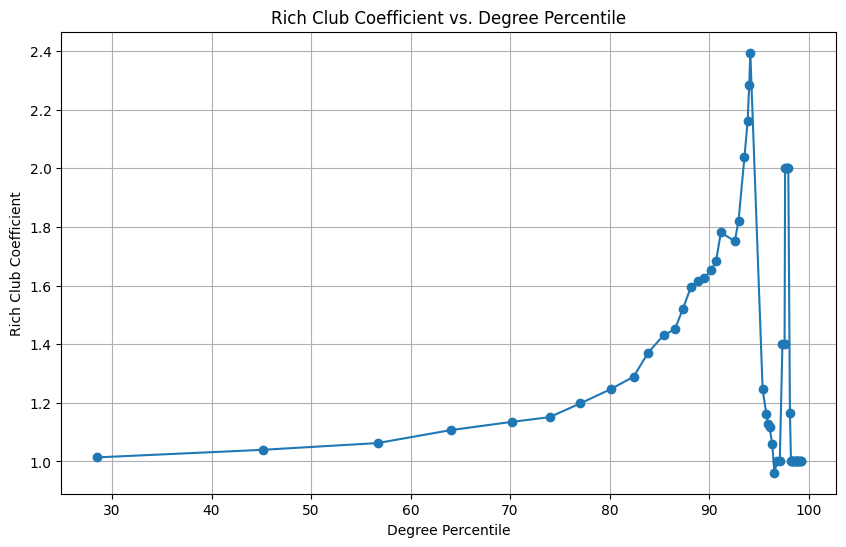

40


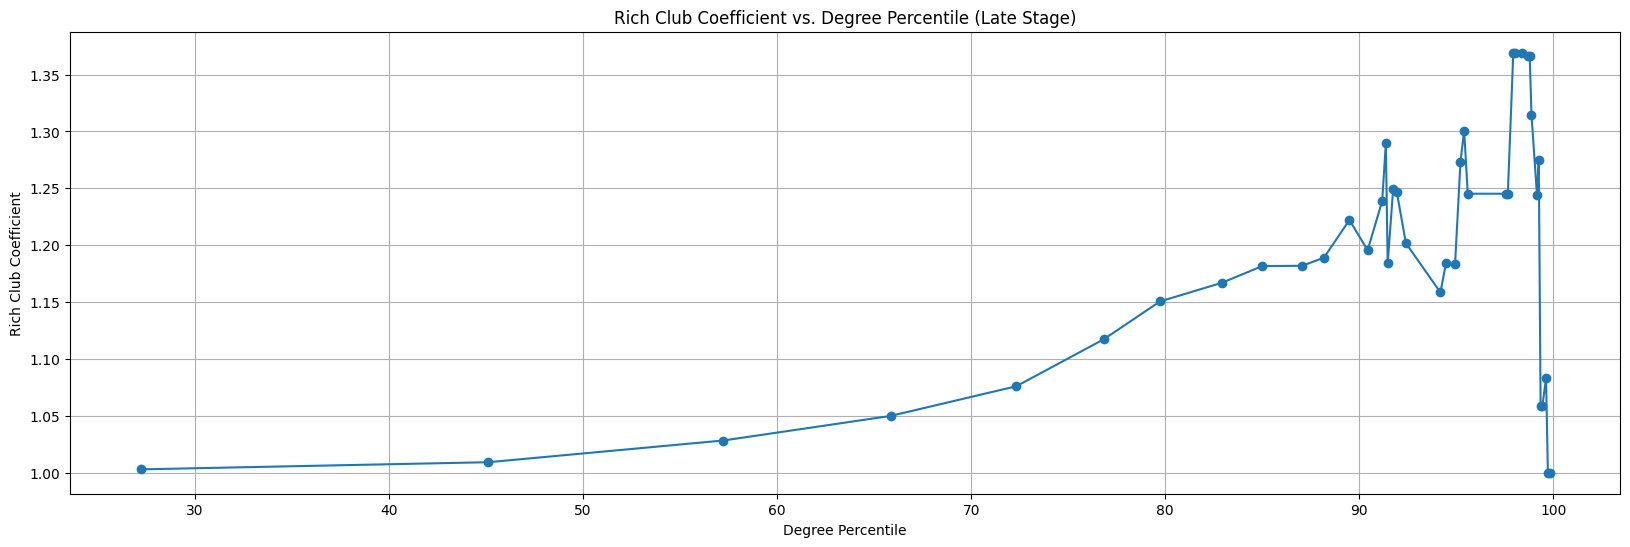

In [673]:
# Calculate the percentiles for the degrees in the graph
degrees = list(node_degrees_early_stage.values())
sorted_degrees = sorted(degrees, reverse=False)
percentiles = [100 * (i / len(sorted_degrees)) for i in range(len(sorted_degrees))]

# Create a mapping from degree to percentile
degree_to_percentile = {degree: percentiles[i] for i, degree in enumerate(sorted_degrees)}
print(degree_to_percentile)

# Map the degrees in the rich club coefficient dictionary to their corresponding percentiles
rich_club_percentiles = {degree_to_percentile[k]: v for k, v in rich_club_coefficient_early_stage.items() if k in degree_to_percentile}

# Plot the rich club coefficient against the percentiles
plt.figure(figsize=(10, 6))

plt.plot(list(rich_club_percentiles.keys()), list(rich_club_percentiles.values()), marker='o')
plt.xlabel('Degree Percentile')
plt.ylabel('Rich Club Coefficient')
plt.title('Rich Club Coefficient vs. Degree Percentile')
plt.grid(True)
plt.show()

# Calculate the percentiles for the degrees in the late stage graph
degrees_late_stage = list(node_degrees_late_stage.values())
sorted_degrees_late_stage = sorted(degrees_late_stage, reverse=False)
percentiles_late_stage = [100 * (i / len(sorted_degrees_late_stage)) for i in range(len(sorted_degrees_late_stage))]

# Create a mapping from degree to percentile for late stage
degree_to_percentile_late_stage = {degree: percentiles_late_stage[i] for i, degree in enumerate(sorted_degrees_late_stage)}

# Map the degrees in the rich club coefficient dictionary to their corresponding percentiles for late stage
rich_club_percentiles_late_stage = {degree_to_percentile_late_stage[k]: v for k, v in rich_club_coefficient_late_stage.items() if k in degree_to_percentile_late_stage}

# Plot the rich club coefficient against the percentiles for late stage
print(len(rich_club_percentiles_late_stage))
plt.figure(figsize=(20, 6))

plt.plot(list(rich_club_percentiles_late_stage.keys()), list(rich_club_percentiles_late_stage.values()), marker='o')
plt.xlabel('Degree Percentile')
plt.ylabel('Rich Club Coefficient')
plt.title('Rich Club Coefficient vs. Degree Percentile (Late Stage)')
plt.grid(True)
plt.show()

In [674]:
# List nodes of early stage graph in descending order of degree
sorted_nodes_early_stage = sorted(node_degrees_early_stage.items(), key=lambda x: x[1], reverse=True)
print("Nodes of Early Stage Graph in Descending Order of Degree:")
for node, degree in sorted_nodes_early_stage[:10]:
    print(f"Node: {node}, Degree: {degree}")

# List nodes of late stage graph in descending order of degree
sorted_nodes_late_stage = sorted(node_degrees_late_stage.items(), key=lambda x: x[1], reverse=True)
print("\nNodes of Late Stage Graph in Descending Order of Degree:")
for node, degree in sorted_nodes_late_stage[:10]:
    print(f"Node: {node}, Degree: {degree}")

Nodes of Early Stage Graph in Descending Order of Degree:
Node: Animoca Brands, Degree: 178
Node: LD Capital, Degree: 107
Node: Exnetwork Capital, Degree: 99
Node: Sequoia Capital, Degree: 96
Node: Y Combinator, Degree: 90
Node: Shima Capital, Degree: 89
Node: Andreessen Horowitz, Degree: 86
Node: Infinity Ventures Crypto, Degree: 81
Node: AU21 Capital, Degree: 80
Node: Morningstar Ventures, Degree: 77

Nodes of Late Stage Graph in Descending Order of Degree:
Node: Sequoia Capital, Degree: 76
Node: Y Combinator, Degree: 63
Node: Andreessen Horowitz, Degree: 54
Node: SV Angel, Degree: 46
Node: Animoca Brands, Degree: 46
Node: Pioneer Fund, Degree: 41
Node: Soma Capital, Degree: 40
Node: Alumni Ventures, Degree: 36
Node: Elad Gil, Degree: 34
Node: Kevin Lin, Degree: 34


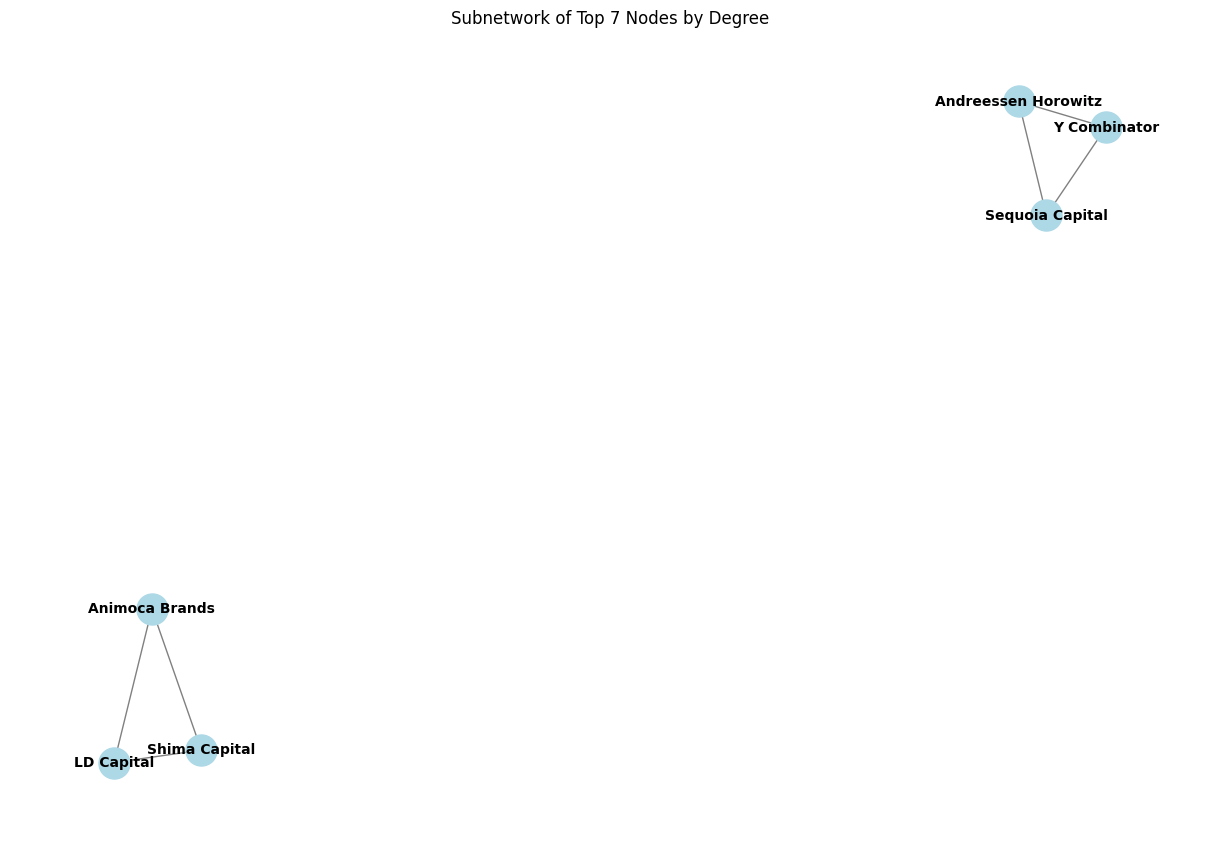

In [675]:
# Get the top 7 nodes by degree
top_7_nodes = [node for node, degree in sorted_nodes_early_stage[:7]]

# Create a subgraph containing only these nodes and their edges
subgraph = G_early_stage_filtered.subgraph(top_7_nodes)

# Plot the subgraph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, k=0.5, iterations=50)
nx.draw(subgraph, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=10, font_weight="bold", edge_color="gray")
plt.title("Subnetwork of Top 7 Nodes by Degree")
plt.show()

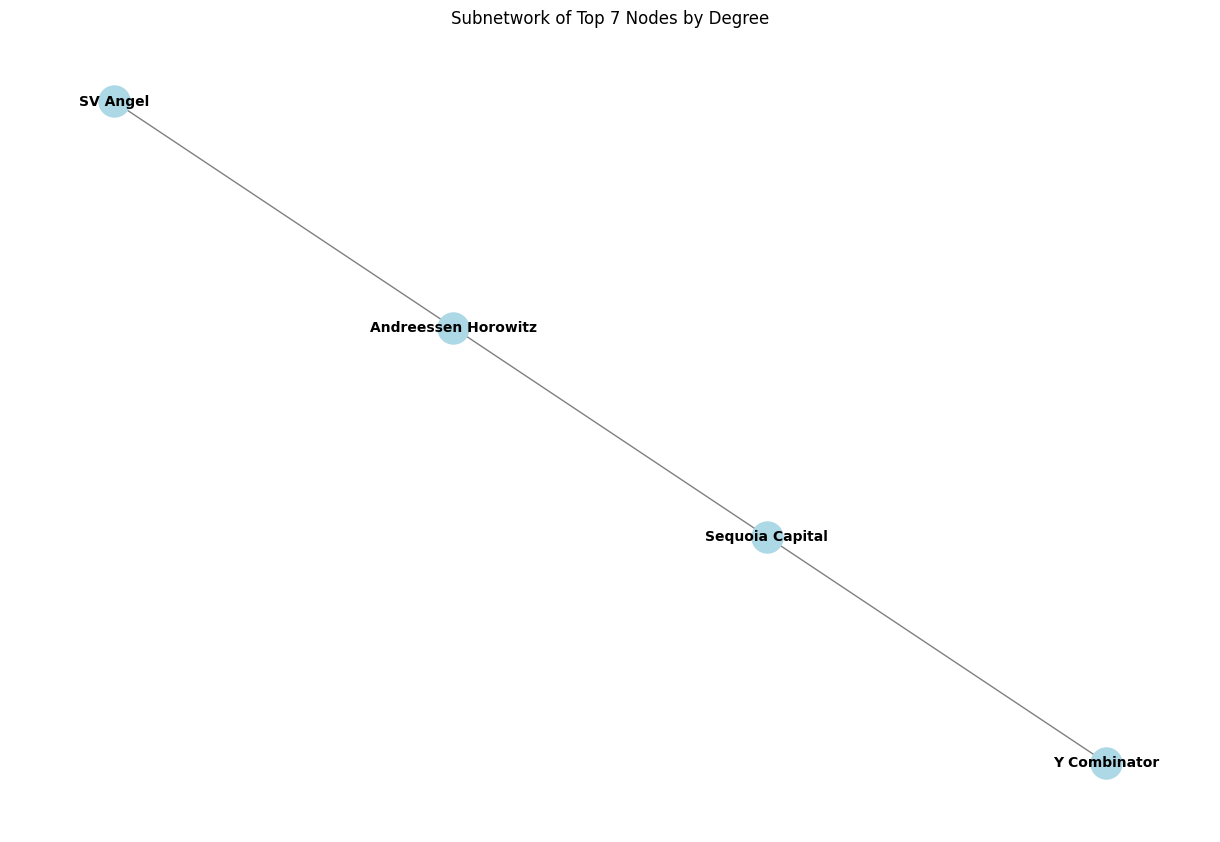

In [676]:
# Get the top 7 nodes by degree
top_7_nodes = [node for node, degree in sorted_nodes_late_stage[:7]]

# Create a subgraph containing only these nodes and their edges
subgraph = G_late_stage_filtered.subgraph(top_7_nodes)

# Plot the subgraph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, k=0.5, iterations=50)
nx.draw(subgraph, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=10, font_weight="bold", edge_color="gray")
plt.title("Subnetwork of Top 7 Nodes by Degree")
plt.show()

In [677]:
def get_top_investors_by_field(investors_df, field, num_investors):
    investors_df[field] = pd.to_numeric(investors_df[field], errors='coerce')
    top_investors_by_field = investors_df.nlargest(num_investors, field)['Investors'].values
    top_investors_in_graph = [investor for investor in top_investors_by_field if investor in G_late_stage.nodes()]

    return top_investors_in_graph

def create_subgraph(graph, nodes):
    return graph.subgraph(nodes)

# Example usage
top_investors_in_graph = get_top_investors_by_field(investors_df, 'AUM', 10)

# Create a subgraph containing only these nodes and their edges
subgraph_top_10 = create_subgraph(G_late_stage, top_investors_in_graph)

# Plot the subgraph as a multipartite graph divided by sub-region
plt.figure(figsize=(12, 8))

# Create a dictionary to map sub-regions to colors
sub_region_colors = {sub_region: color for sub_region, color in zip(top_investors_df_sorted['HQ Global Sub Region'].unique(), sns.color_palette("hsv", len(top_investors_df_sorted['HQ Global Sub Region'].unique())))}

# Assign colors to nodes based on their sub-region
node_colors = [sub_region_colors[top_investors_df_sorted[top_investors_df_sorted['Investors'] == node]['HQ Global Sub Region'].values[0]] for node in subgraph_top_10.nodes()]

# Create a layout for the graph
pos = nx.spring_layout(subgraph_top_10, k=0.5, iterations=50)

# Draw the graph
nx.draw(subgraph_top_10, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10, font_weight="bold", edge_color="gray")

# Create a legend for the sub-regions
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=sub_region) for sub_region, color in sub_region_colors.items()]
plt.legend(handles=handles, title="HQ Global Sub Region", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Subnetwork of Top 10 Investors by AUM Divided by Sub-Region")
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1200x800 with 0 Axes>

## Plot Graph

In [ ]:
node_labels = {node: node for node in G.nodes()}

# Print graph edges with shared active investors
print("Graph Edges:")
print(len(G.edges()))
for edge in G.edges(data=True):
    print(edge)

pos = nx.spring_layout(G, k=5, iterations=100)  # Layout for visualization
nx.draw(G, pos, with_labels=False, labels=node_labels, node_color="lightblue", node_size=15)
# plt.show()

## Save Graph to GEXF

In [595]:
nx.write_gexf(G_early_stage_filtered, "co_investment_early_stage_filtered.gexf")

In [596]:
nx.write_gexf(G_late_stage_filtered, "co_investment_late_stage_filtered.gexf")